##6.1. Exploratory Data Analysis (EDA)

Langkah 1: Import Library & Load Data Kita perlu menyiapkan alat (library) dan memuat data mentah ke dalam memori.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data
df = pd.read_csv('smart_traffic_management_dataset.csv')

print("Data berhasil dimuat. 5 Baris teratas:")
print(df.head())

Data berhasil dimuat. 5 Baris teratas:
             timestamp  location_id  traffic_volume  avg_vehicle_speed  \
0  2024-01-01 00:00:00            4             504          53.124162   
1  2024-01-01 00:01:00            5             209          44.947850   
2  2024-01-01 00:02:00            3             572          63.179229   
3  2024-01-01 00:03:00            5             699          42.269697   
4  2024-01-01 00:04:00            5             639          72.185791   

   vehicle_count_cars  vehicle_count_trucks  vehicle_count_bikes  \
0                 142                    24                   44   
1                 862                    50                   23   
2                 317                    12                   10   
3                 709                    43                   21   
4                 594                    34                   14   

  weather_condition  temperature   humidity  accident_reported signal_status  
0            Cloudy    33.33

Langkah 2: Konversi Tipe Data Waktu Data waktu biasanya terbaca sebagai teks (string). Kita harus mengubahnya agar mesin mengerti konsep "Jam" dan "Hari".

In [2]:
# Konversi kolom timestamp ke datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timestamp             2000 non-null   datetime64[ns]
 1   location_id           2000 non-null   int64         
 2   traffic_volume        2000 non-null   int64         
 3   avg_vehicle_speed     2000 non-null   float64       
 4   vehicle_count_cars    2000 non-null   int64         
 5   vehicle_count_trucks  2000 non-null   int64         
 6   vehicle_count_bikes   2000 non-null   int64         
 7   weather_condition     2000 non-null   object        
 8   temperature           2000 non-null   float64       
 9   humidity              2000 non-null   float64       
 10  accident_reported     2000 non-null   int64         
 11  signal_status         2000 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(6), object(2)
memory usage: 187.6+ K

Langkah 3: Visualisasi Distribusi (Cek Data) Kita membuat grafik untuk melihat apakah data lalu lintas tersebar merata atau berat sebelah.

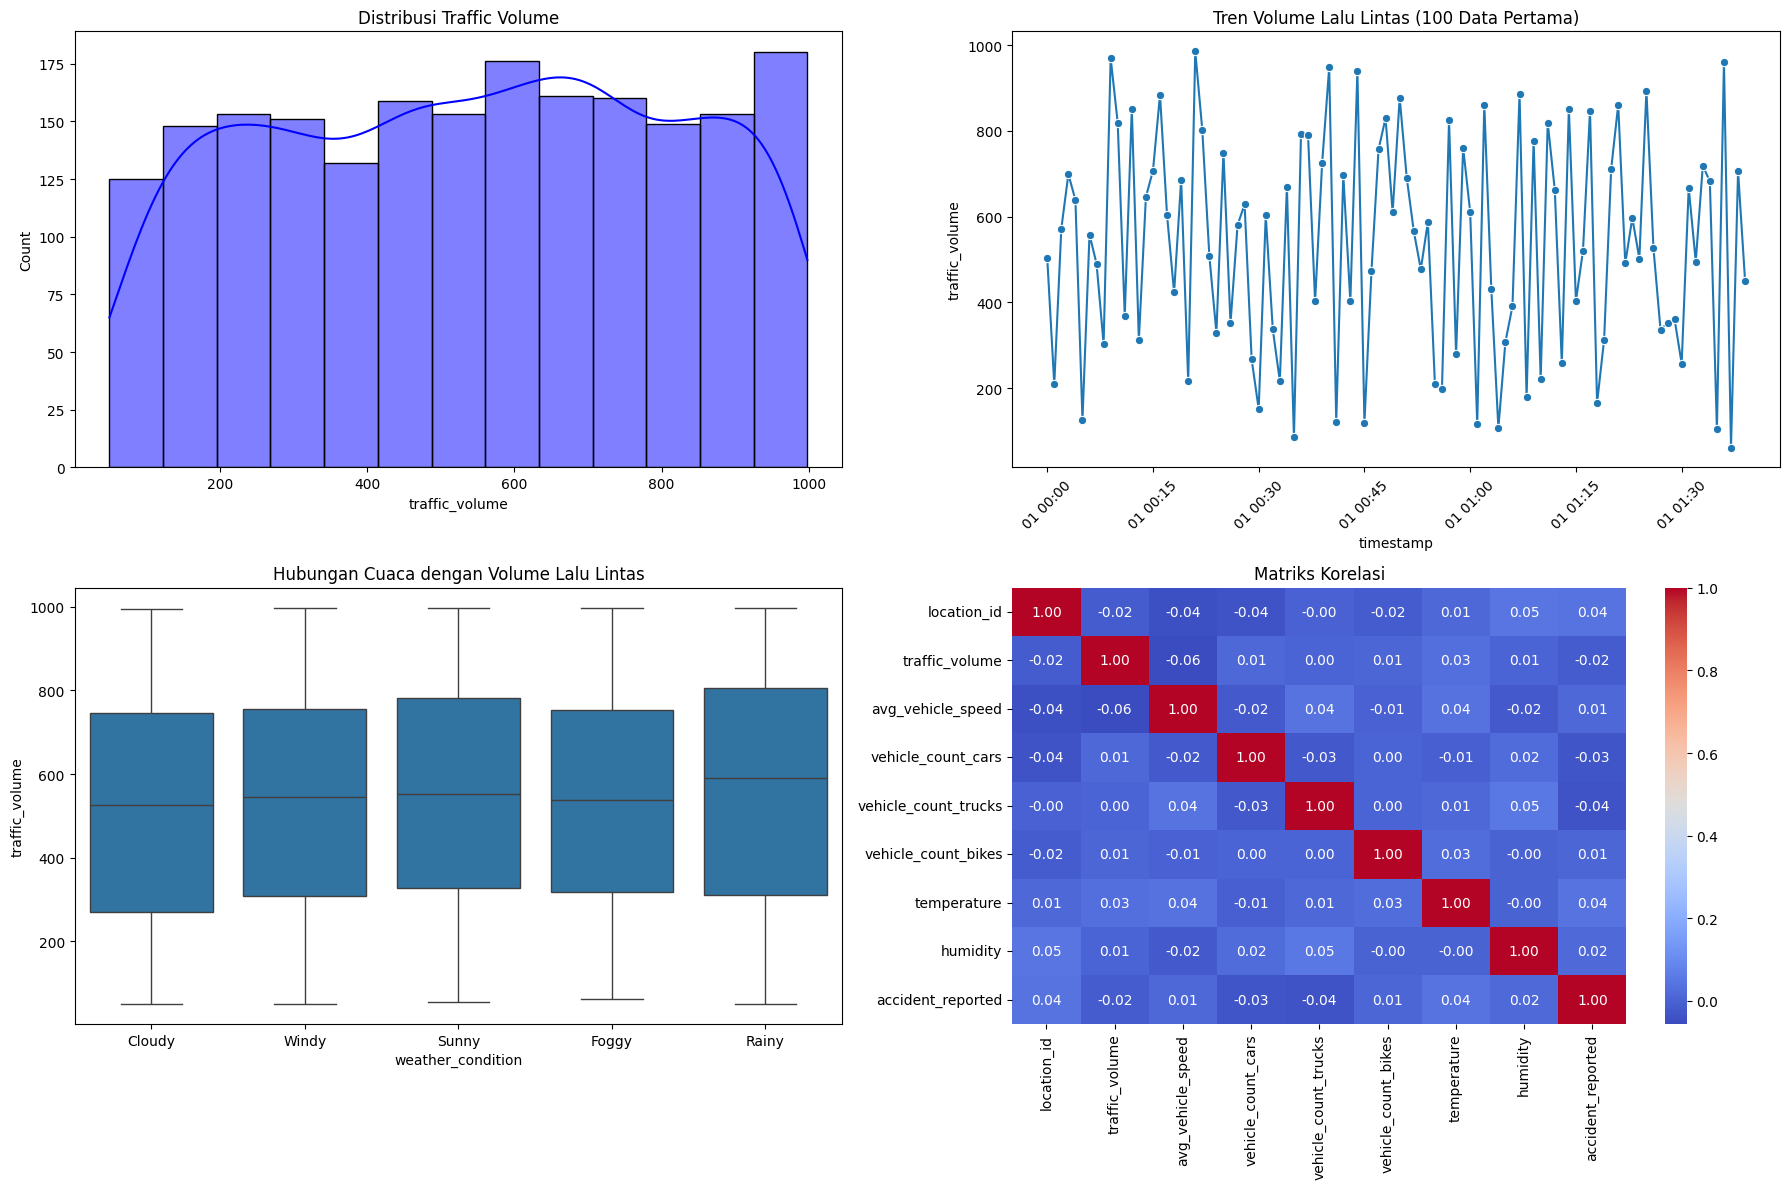

In [3]:
plt.figure(figsize=(18, 12))

# 1. Visualisasi Distribusi Volume (Histogram)
plt.subplot(2, 2, 1)
sns.histplot(df['traffic_volume'], kde=True, color='blue')
plt.title('Distribusi Traffic Volume')

# 2. Visualisasi Tren Waktu (Line Plot - Sampel 100 data pertama agar terbaca)
plt.subplot(2, 2, 2)
sns.lineplot(data=df.iloc[:100], x='timestamp', y='traffic_volume', marker='o')
plt.title('Tren Volume Lalu Lintas (100 Data Pertama)')
plt.xticks(rotation=45)

# 3. Visualisasi Pengaruh Cuaca (Box Plot)
plt.subplot(2, 2, 3)
sns.boxplot(x='weather_condition', y='traffic_volume', data=df)
plt.title('Hubungan Cuaca dengan Volume Lalu Lintas')

# 4. Visualisasi Matriks Korelasi (Heatmap)
plt.subplot(2, 2, 4)
# Pilih hanya kolom numerik untuk korelasi
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriks Korelasi')

plt.tight_layout()
plt.show()

## 6.2 Data Preprocessing

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Handling Missing Values
df = df.dropna()

In [5]:
# 2. Feature Engineering (Ekstrak informasi waktu)
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

In [6]:
# 3. Encoding Categorical Features (One-Hot Encoding)
# Mengubah Cuaca dan Signal menjadi angka
df_processed = pd.get_dummies(df, columns=['weather_condition', 'signal_status'], drop_first=True)

In [7]:
# 4. Feature Selection (Memilih X dan y)
# Drop kolom yang tidak dipakai untuk prediksi
X = df_processed.drop(['traffic_volume', 'timestamp', 'location_id', 'accident_reported'], axis=1)
y = df_processed['traffic_volume']

In [8]:
# 5. Train-Test Split (80% Latih, 20% Uji)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# 6. Scaling / Normalization
# Penting terutama untuk algoritma KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dimensi Data Training:", X_train.shape)
print("Dimensi Data Testing :", X_test.shape)

Dimensi Data Training: (1600, 14)
Dimensi Data Testing : (400, 14)


## 6.3 Modeling

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Inisialisasi Model
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

trained_models = {}

# Training Loop
for name, model in models.items():
    # Gunakan data yang sudah di-scaling untuk semua agar adil (KNN wajib scaling)
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    print(f"Model {name} selesai dilatih.")

Model Decision Tree selesai dilatih.
Model Random Forest selesai dilatih.
Model KNN selesai dilatih.


## 6.4 Evaluasi

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

results = []

# --- 1. PROSES HITUNG METRIK ---
for name, model in trained_models.items():
    # Prediksi
    y_pred = model.predict(X_test_scaled)

    # Hitung Metrik
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Simpan hasil
    results.append({'Model': name, 'R2': r2, 'MAE': mae, 'RMSE': rmse})

# Buat DataFrame hasil
results_df = pd.DataFrame(results)

# --- 2. TAMPILKAN TABEL HASIL SEMUA MODEL (DI ATAS GRAFIK) ---
print("\n" + "="*60)
print("             HASIL DETAIL EVALUASI SEMUA MODEL")
print("="*60)
# Menampilkan dataframe dengan format rapi tanpa index
print(results_df.round(4).to_string(index=False))
print("="*60 + "\n")


             HASIL DETAIL EVALUASI SEMUA MODEL
        Model      R2      MAE     RMSE
Decision Tree -1.0536 311.0900 381.6141
Random Forest -0.0115 224.8030 267.8199
          KNN -0.1649 239.0395 287.4187



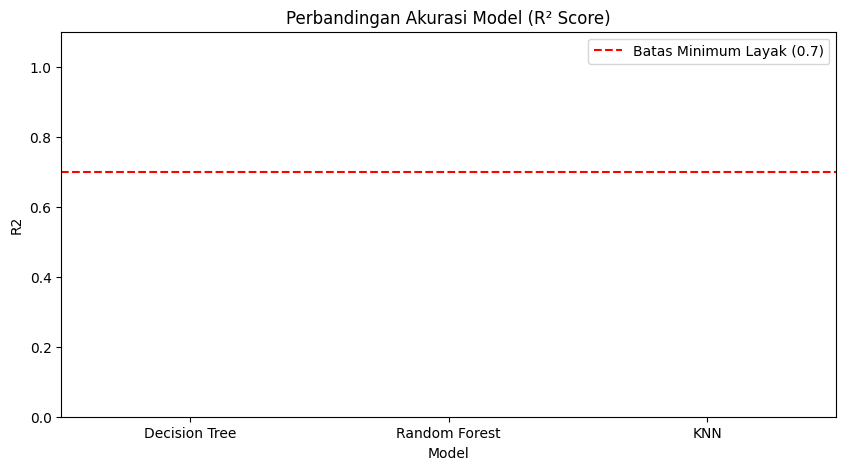

In [12]:
# --- 3. VISUALISASI PERBANDINGAN ---
plt.figure(figsize=(10, 5))

# Plotting dengan perbaikan warning (hue & legend)
sns.barplot(x='Model', y='R2', data=results_df, palette='viridis', hue='Model', legend=False)

plt.title('Perbandingan Akurasi Model (R² Score)')
plt.ylim(0, 1.1) # Batas maksimal 1.0
plt.axhline(0.7, color='red', linestyle='--', label='Batas Minimum Layak (0.7)')
plt.legend()
plt.show()

In [13]:
# --- 4. KESIMPULAN MODEL TERBAIK ---
# Mencari model dengan R2 Score tertinggi
best_row = results_df.loc[results_df['R2'].idxmax()]
best_model_name = best_row['Model']
best_r2 = best_row['R2']
best_mae = best_row['MAE']
best_rmse = best_row['RMSE']

print("\n" + "="*60)
print("             KESIMPULAN AKHIR (REKOMENDASI)")
print("="*60)
print(f"MODEL TERBAIK: {best_model_name.upper()}")
print("-" * 45)
print("Indikator Performa:")
print(f"Akurasi (R² Score)       : {best_r2:.4f}")
print(f"Rata-rata Error (MAE)    : {best_mae:.2f} Kendaraan")
print(f"Root Mean Square (RMSE)  : {best_rmse:.2f}")
print("-" * 45)

# Simpan variabel model terbaik
best_model = trained_models[best_model_name]


             KESIMPULAN AKHIR (REKOMENDASI)
MODEL TERBAIK: RANDOM FOREST
---------------------------------------------
Indikator Performa:
Akurasi (R² Score)       : -0.0115
Rata-rata Error (MAE)    : 224.80 Kendaraan
Root Mean Square (RMSE)  : 267.82
---------------------------------------------


## 6.5 Deployment

In [14]:
import joblib

# Simpan model terbaik
filename = 'traffic_model_final.pkl'
joblib.dump(best_model, filename)

# Simpan juga scalernya (penting agar input data baru bisa di-scaling sama persis)
joblib.dump(scaler, 'scaler.pkl')

print(f"Model terbaik ({best_model_name}) berhasil disimpan sebagai '{filename}'")
print("Scaler berhasil disimpan sebagai 'scaler.pkl'")

Model terbaik (Random Forest) berhasil disimpan sebagai 'traffic_model_final.pkl'
Scaler berhasil disimpan sebagai 'scaler.pkl'


#Jumlah Data Untuk Panduan Testing Deploy

In [15]:
print(df['traffic_volume'].describe())

count    2000.000000
mean      540.959000
std       271.933985
min        50.000000
25%       309.000000
50%       549.000000
75%       774.000000
max       998.000000
Name: traffic_volume, dtype: float64
